In [136]:
# -*- coding: utf-8 -*- Line 2
#----------------------------------------------------------------------------
# Project     : Price Alarm System Enhancement - Alarm2
# Created By  : Eungi Cho
# Created Date: 03/06/22
# Updated Date: 09/06/22
# version ='1.0'
# ---------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
plt.style.use('default')

In [137]:
import pathlib
print(pathlib.Path().absolute())
df_raw = pd.read_csv('/Users/cho-eungi/Practice/CSV/market_entry_price.csv')
print(df_raw.shape)
# print(df_raw.isnull().sum())
df_raw = df_raw.drop_duplicates()
df_raw.head()

/Users/cho-eungi/Practice/Tridge
(10619563, 11)


,source_id,country,market_id,product_id,entry_id,currency,final_unit,date,price_min,price_max,price_avg
0,201,South Africa,1487,131,92926374,ZAR,kg,2020-07-20,19.64,21.2,19.956
1,39,India,810,490,41039702,INR,kg,2020-07-06,11.80,12.5,12.200
2,41,India,2188,133,50157058,INR,kg,2020-07-06,50.00,52.7,51.400
3,556,Bangladesh,6581,545,84458922,BDT,kg,2020-07-13,4400.00,4800.0,4600.000
4,150,Turkey,2482,126,58387432,TRY,NaN,2020-07-13,10.00,15.0,11.288


In [141]:
# Create Test df
entry_lst = np.sort(df_raw['entry_id'].unique())
np.random.seed(0)
sample_entry = np.random.choice(entry_lst, 500)
test_df = df_raw.loc[df_raw['entry_id'].isin(sample_entry)].sort_values(
    by = ['source_id', 'market_id', 'entry_id', 'date']).copy()
test_df['date'] = pd.to_datetime(test_df['date'])

In [142]:
# W-MON date range from 2020 to 2022
# Left Join Test DF and Time DF
empty_df = pd.DataFrame()
for entry in sample_entry:
    entry_start = min(df_raw.loc[df_raw['entry_id'] == entry]['date'])
    date_range = pd.date_range(entry_start, '2022-05-31', freq = 'W-MON')
    time_df = pd.DataFrame({'date': date_range})
    
    time_df['entry_id_'] = entry
    entry_df = test_df.loc[test_df['entry_id'] == entry]
    joined_df = pd.merge(time_df, entry_df, left_on = ['date'], right_on = ['date'], how = 'left')
    empty_df = empty_df.append(joined_df)

df = empty_df.copy()
df = df.sort_values(by = ['entry_id_', 'date'])
df.set_index(np.arange(len(df)), inplace=True)
len(df.entry_id_.unique())

500

In [146]:
df

,date,entry_id_,source_id,country,market_id,product_id,entry_id,currency,final_unit,price_min,price_max,price_avg,consec_null,consec_null_shift,freq,threshold,freq_judge,alarm2
0,2020-01-06,40860394,16.0,China,3494.0,235.0,40860394.0,CNY,kg,5.00,6.00,5.733333,0,NaN,0.0,2.0,0.0,0
1,2020-01-13,40860394,16.0,China,3494.0,235.0,40860394.0,CNY,kg,4.40,6.00,5.142857,0,0.0,1.0,2.0,1.0,0
2,2020-01-20,40860394,16.0,China,3494.0,235.0,40860394.0,CNY,kg,5.00,6.20,5.866667,0,0.0,1.0,2.0,1.0,0
3,2020-01-27,40860394,16.0,China,3494.0,235.0,40860394.0,CNY,kg,5.80,7.00,6.633333,0,0.0,1.0,2.0,1.0,0
4,2020-02-03,40860394,16.0,China,3494.0,235.0,40860394.0,CNY,kg,5.60,7.00,6.266667,0,0.0,1.0,2.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41294,2022-05-30,133882210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,NaN,inf,1.0,0
41295,2022-05-23,134082497,169.0,France,132.0,132.0,134082497.0,EUR,NaN,3.65,3.65,3.650000,0,NaN,0.0,inf,0.0,0
41296,2022-05-30,134082497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,NaN,inf,1.0,0
41297,2022-05-23,134278888,646.0,South Africa,758.0,117.0,134278888.0,ZAR,kg,40.00,60.00,44.000000,0,NaN,0.0,inf,0.0,0


In [143]:
# Initialize df_stats DataFrame
df_stats = df[['date', 'entry_id_', 'product_id', 'price_avg']]

In [144]:
# Count the occurances of consecutive null value
def count_consec_nan(array):
    consec_cnt = array.isnull().astype(int).groupby(array.notnull().astype(int).cumsum()).cumsum()
    return np.asarray(consec_cnt)
one_freq_0_lst1 = []
one_freq_0_lst2 = []
one_freq_not0_lst3 = []
multi_freq_lst1 = []
multi_freq_lst2 = []
multi_freq_lst3 = []
multi_freq_lst4 = []

def alarm_2(df):
    # 연속적으로 null 이 보고되는 횟수를 담은 column: consec_null
    # consec_null 의 shift(1) column: consec_null_shift
    df['consec_null'] = df.groupby('entry_id_')['price_avg'].transform(count_consec_nan)
    df['consec_null_shift'] = df.groupby('entry_id_')['consec_null'].shift(1)
    
    # Logic 상세 설명 - consec_null 와 consec_null_shift 비교:
    # entry_id의 Price의 첫 보고일 2020.10.05: consec_null == 0, consec_null_shift == NaN, freq == 0
    # 다음 Price 보고일 2020.10.12: consec_null == 0, consec_null_shift == 0, freq == 1
    # 다음 Price 보고일 2020.10.19: consec_null == 0, consec_null_shift == 0, freq == 1
    # 다음 Price 보고일 2020.11.09(3주차에 보고): consec_null == 0, consec_null_shift == 2, freq == 3
    
    # conditions[0]: Price 첫 보고일 // conditions[1]: 다음 Price 보고일
    # freq 결과값: 첫 보고일 = 0, 다음 보고일 = price 가 보고되지 않고 있던 주기 + 1, 보고 x = price 가 보고되지 않고 있던 주기
    conditions  = [ (df['consec_null'] == 0) & (df['consec_null_shift'].isnull()),
                   (df['consec_null'] == 0) & (df['consec_null_shift'].notnull())]
    choices     = [ 0, df['consec_null_shift'] + 1]
    df["freq"] = np.select(conditions, choices, default=np.nan)
    
    # 해당 entry_id의 Price의 주 보고 기간의 최빈값 계산. 복수 개의 최빈값이 있을 경우, 리스트 형태로 닮김.
    entry_freq = df.groupby('entry_id_')['freq'].agg(pd.Series.mode).to_dict()
    
    # 최빈값 Dict 생성
    # threshold의 용도: if frequency > threshold, then raise alarm2
    threshold_dict = {}
    for entry, freq in entry_freq.items():
        # 최빈값이 단일값만 존재할 경우:
        if isinstance(freq, float):
            # 최빈값이 단일값만 존재하는 경우
            # freq = 0이라는 것은 단 한 번 Price가 보고된 후, 그 이후로는 보고되지 않고 있다는 뜻.
            if freq == 0:
                timedelt = round((pd.Timestamp(2022, 5, 31) - min(df.loc[df['entry_id_'] == entry]['date'])) / np.timedelta64(1, 'M'))
                # 2022/05/31 기준 2개월 이내 추가된 entry일 경우는 threshold를 np.inf으로 설정.
                if timedelt <= 2:
                    print('Reported only one time but the first reported date <= 2 month: entry, freq, timedelt = ', entry, freq, timedelt)
                    one_freq_0_lst1.append(entry)
                    threshold_dict[entry] = np.inf
                # 그렇지 않다면, threshold를 np.NINF 으로 설정 (즉, 이 경우에는 무조건 alarm 2에 포함)
                else:
                    print('Reported only one time but the first reported date > 2 month: entry, freq, timedelt = ', entry, freq, timedelt)
                    one_freq_0_lst2.append(entry)
                    threshold_dict[entry] = np.NINF
            else:
                print('Reported regularly: entry, freq', entry, freq)
                one_freq_not0_lst3.append(entry)
                threshold_dict[entry] = freq * 2

        # 최빈값이 두 개 이상 존재: 매우 불규칙하게 보고되어서 일정한 주기가 없는 경우
        # 이 때 threshold 설정은 0과 1을 제외한 min값
        else:
            # 최빈값이 [0, 1] 일 경우. 즉 최초 한 번과 바로 그 다음 주기에 price가 보고된 후 한 번도 들어오지 않은 경우
            if (len(freq) == 2) & (np.min(freq) == 0) & (freq[np.where(freq == np.min(freq))[0][0] + 1] == 1):
                timedelt = round((pd.Timestamp(2022, 5, 31) - min(df.loc[df['entry_id_'] == entry]['date'])) / np.timedelta64(1, 'M'))
                # 2022/05/31 기준 2개월 이내 추가된 entry일 경우는 threshold를 np.inf으로 설정.
                if timedelt <= 2:
                    print('Reported only 2 times consecutively but the first reported date <= 2 month: entry, freq =', entry, freq)
                    multi_freq_lst1.append(entry)
                    threshold_dict[entry] = np.inf
                # 그렇지 않다면, threshold를 np.NINF 으로 설정 (즉, 이 경우에는 무조건 alarm 2에 포함)
                else:
                    print('Reported only 2 times consecutively but the first reported date > 2 month: entry, freq =', entry, freq)
                    multi_freq_lst2.append(entry)
                    threshold_dict[entry] = np.NINF

            # 최빈값이 [0,1,3,10,...] 등 최초 한 번 보고된 후에도 매우 불규칙적으로 보고되고 있는 entry일 경우
            else:
                value = freq[np.where(freq == np.min(freq))[0][0] + 1]
                if value == 1:
                    multi_freq_lst3.append(entry)
                    value = freq[np.where(freq == np.min(freq))[0][0] + 2]
                    print('Reported unregularly case 1 - [0, 1, 3, 10...], entry, freq, 0 next', entry, freq, value)
                    threshold_dict[entry] = value * 2
                else:
                    multi_freq_lst4.append(entry)
                    print('Reported unregularly case 2 - [0, 3, 9, 11...], entry, freq, 0 next', value)
                    threshold_dict[entry] = value * 2
    def find_threshold(row):
        threshold_col = [threshold for entry, threshold in threshold_dict.items() if row['entry_id_'] == entry]
        return np.asarray(threshold_col[0])

    df['threshold'] = df.apply(lambda row: find_threshold(row), axis = 1)
    
    conditions  = [ (df['consec_null'] == 0) & (df['consec_null_shift'].isnull()),
               (df['consec_null'] == 0) & (df['consec_null_shift'].notnull()),
            (df['consec_null'] != 0) & (df['consec_null_shift'].notnull())]
    
    choices     = [ 0, df['freq'], df['consec_null']]
    
    df["freq_judge"] = np.select(conditions, choices)
    df['alarm2'] = np.where(df['freq_judge'] > df['threshold'], 1, 0)

In [145]:
alarm_2(df)

Reported regularly: entry, freq 40860394 1.0
Reported regularly: entry, freq 40862556 1.0
Reported regularly: entry, freq 40863754 1.0
Reported regularly: entry, freq 40863763 1.0
Reported regularly: entry, freq 40865627 1.0
Reported regularly: entry, freq 40867745 1.0
Reported regularly: entry, freq 40867867 1.0
Reported regularly: entry, freq 40868159 1.0
Reported regularly: entry, freq 40869263 1.0
Reported regularly: entry, freq 40869632 1.0
Reported regularly: entry, freq 40870996 1.0
Reported regularly: entry, freq 40871564 1.0
Reported regularly: entry, freq 40871981 1.0
Reported regularly: entry, freq 40872219 1.0
Reported regularly: entry, freq 40872365 1.0
Reported regularly: entry, freq 40873446 1.0
Reported regularly: entry, freq 40873670 1.0
Reported regularly: entry, freq 40873737 1.0
Reported regularly: entry, freq 40873863 1.0
Reported regularly: entry, freq 40874310 1.0
Reported regularly: entry, freq 40874750 1.0
Reported regularly: entry, freq 40874797 1.0
Reported r

Reported only one time but the first reported date > 2 month: entry, freq, timedelt =  116925480 0.0 4
Reported regularly: entry, freq 117027459 1.0
Reported regularly: entry, freq 117313487 1.0
Reported unregularly case 1 - [0, 1, 3, 10...], entry, freq, 0 next 117313825 [0. 1. 3. 4.] 3.0
Reported regularly: entry, freq 117313996 1.0
Reported regularly: entry, freq 117314067 1.0
Reported regularly: entry, freq 117342921 1.0
Reported regularly: entry, freq 117344858 1.0
Reported only 2 times consecutively but the first reported date > 2 month: entry, freq = 117836300 [0. 1.]
Reported regularly: entry, freq 117880614 1.0
Reported only one time but the first reported date > 2 month: entry, freq, timedelt =  117978150 0.0 3
Reported only one time but the first reported date > 2 month: entry, freq, timedelt =  118048632 0.0 4
Reported regularly: entry, freq 118103315 1.0
Reported regularly: entry, freq 118184625 4.0
Reported regularly: entry, freq 118377194 1.0
Reported regularly: entry, f

In [149]:
print('\n',
    f'Reported only one time but the first reported date <= 2 month:                       {len(one_freq_0_lst1)}, rate: {len(one_freq_0_lst1) * 100 / len(df.entry_id_.unique()):.2f}%\n',
    f'Reported only one time but the first reported date > 2 month:                        {len(one_freq_0_lst2)}, rate: {len(one_freq_0_lst2) * 100 / len(df.entry_id_.unique()):.2f}%\n',
    f'Reported regularly:                                                                  {len(one_freq_not0_lst3)}, rate: {len(one_freq_not0_lst3) * 100 / len(df.entry_id_.unique()):.2f}%\n',
    f'Reported only 2 times consecutively but the first reported date <= 2 month :         {len(multi_freq_lst1)}, rate: {len(multi_freq_lst1) * 100 / len(df.entry_id_.unique()):.2f}%\n',
    f'Reported only 2 times consecutively but the first reported date > 2 month:           {len(multi_freq_lst2)}, rate: {len(multi_freq_lst2) * 100 / len(df.entry_id_.unique()):.2f}%\n',
    f'Reported unregularly:                                                                {len(multi_freq_lst3) + len(multi_freq_lst4)}, rate: {(len(multi_freq_lst3)+(len(multi_freq_lst4))) * 100 / len(df.entry_id_.unique()):.2f}%\n',
)


 Reported only one time but the first reported date <= 2 month:                       8, rate: 1.60%
 Reported only one time but the first reported date > 2 month:                        78, rate: 15.60%
 Reported regularly:                                                                  345, rate: 69.00%
 Reported only 2 times consecutively but the first reported date <= 2 month :         3, rate: 0.60%
 Reported only 2 times consecutively but the first reported date > 2 month:           17, rate: 3.40%
 Reported unregularly:                                                                49, rate: 9.80%



In [182]:
for entry in one_freq_not0_lst3:
    test = df[df['entry_id_'] == entry]
    if (test['threshold'].mean() > 2) & (test['price_avg'].notnull().sum() > 0.2 * len(test)):
        print(entry)
test = df[df['entry_id_'] == 83251989]
print(len(test))
print(test['threshold'].mean())
print(test['price_avg'].notnull().sum())
test

41621691
83251989
102912892
123
8.0
27


,date,entry_id_,source_id,country,market_id,product_id,entry_id,currency,final_unit,price_min,price_max,price_avg,consec_null,consec_null_shift,freq,threshold,freq_judge,alarm2
26367,2020-01-27,83251989,626.0,Philippines,5552.0,257.0,83251989.0,PHP,kg,20.36,20.36,20.36,0,NaN,0.0,8.0,0.0,0
26368,2020-02-03,83251989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,NaN,8.0,1.0,0
26369,2020-02-10,83251989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,NaN,8.0,2.0,0
26370,2020-02-17,83251989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2.0,NaN,8.0,3.0,0
26371,2020-02-24,83251989,626.0,Philippines,5552.0,257.0,83251989.0,PHP,kg,22.08,22.08,22.08,0,3.0,4.0,8.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26485,2022-05-02,83251989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,11.0,NaN,8.0,12.0,1
26486,2022-05-09,83251989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,12.0,NaN,8.0,13.0,1
26487,2022-05-16,83251989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,13.0,NaN,8.0,14.0,1
26488,2022-05-23,83251989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,14.0,NaN,8.0,15.0,1


In [125]:
alarm2_lst = df[df['alarm2'] == 1]['entry_id_'].unique()
print(f'# of entries corresponding to alarm 2: {len(alarm2_lst)} / {len(df.entry_id_.unique())},    Rate: {len(alarm2_lst)*100 / len(df.entry_id_.unique()):.0f}%')

# of entries corresponding to alarm 2: 92 / 100,    Rate: 92%


In [126]:
cases = [one_freq_0_lst1, one_freq_0_lst2,one_freq_not0_lst3,multi_freq_lst1,multi_freq_lst2,multi_freq_lst3, multi_freq_lst4]
error_cnt = []
for case in cases:
    error = len([entry for entry in case if entry in alarm2_lst])
    error_cnt.append(error)

print('\n',
    f'Reported only one time but the first reported date <= 2 month:                      {error_cnt[0]}, {len(one_freq_0_lst1)}\n',
    f'Reported only one time but the first reported date > 2 month:                       {error_cnt[1]}, {len(one_freq_0_lst2)}\n',
    f'Reported regularly:                                                                 {error_cnt[2]}, {len(one_freq_not0_lst3)}\n',
    f'Reported only 2 times consecutively but the first reported date <= 2 month:         {error_cnt[3]}, {len(multi_freq_lst1)}\n',
    f'Reported only 2 times consecutively but the first reported date > 2 month:          {error_cnt[4]}, {len(multi_freq_lst2)}\n',
    f'Reported unregularly:                                                               {error_cnt[5] + error_cnt[6]}, {len(multi_freq_lst3) + len(multi_freq_lst4_)}\n'
)


 Reported only one time but the first reported date <= 2 month:                      0, 2
 Reported only one time but the first reported date > 2 month:                       16, 16
 Reported regularly:                                                                 65, 66
 Reported only 2 times consecutively but the first reported date <= 2 month:         0, 2
 Reported only 2 times consecutively but the first reported date > 2 month:          3, 3
 Reported unregularly:                                                               8, 6



In [127]:
df_stats = pd.concat([df_stats, df[['consec_null', 'threshold', 'freq_judge', 'alarm2']]], axis = 1)
df_stats.head()

,date,entry_id_,product_id,price_avg,consec_null,threshold,freq_judge,alarm2
0,2020-01-06,40867745,206.0,61.75,0,2.0,0.0,0
1,2020-01-13,40867745,NaN,NaN,1,2.0,1.0,0
2,2020-01-20,40867745,NaN,NaN,2,2.0,2.0,0
3,2020-01-27,40867745,206.0,48.50,0,2.0,3.0,1
4,2020-02-03,40867745,NaN,NaN,1,2.0,1.0,0


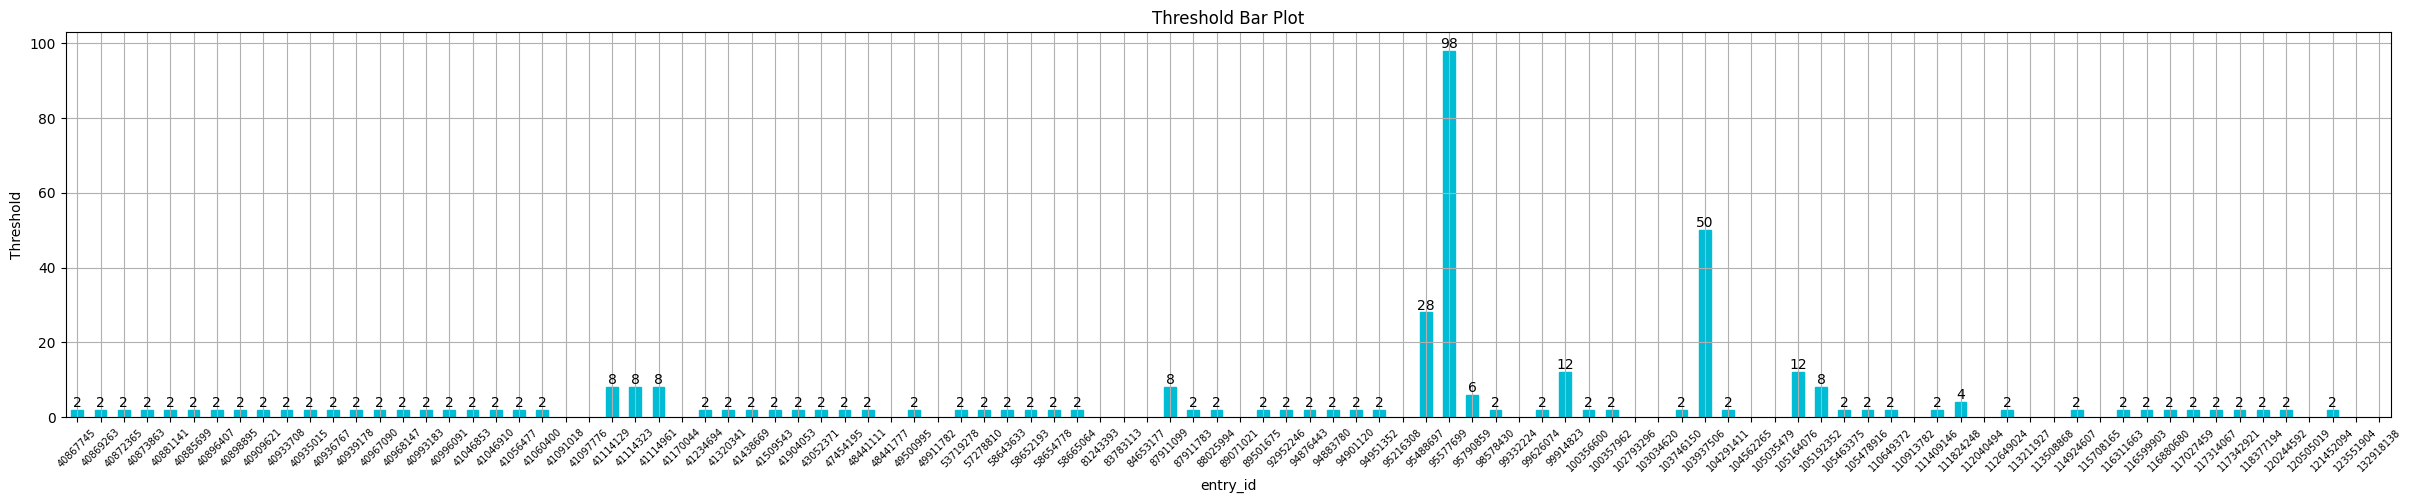

In [135]:
threshold_series = df_stats.groupby('entry_id_')['threshold'].nth(1)
# threshold_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# threshold_df['threshold'] = threshold_df['threshold'].astype(float)
threshold_series = threshold_series.astype(float) 
ax = threshold_series.plot.bar(
    figsize = (30,5), title = 'Threshold Bar Plot', 
    fontsize = 10, color='#00bcd4', edgecolor='#00bcd4', linestyle='-',
    legend = False, grid = True, xlabel = 'entry_id', ylabel = 'Threshold'
)
ax.bar_label(ax.containers[0])
plt.xticks(fontsize = 7, rotation = 45)
plt.show()

Reported less than 3 times (consecutively X)
Sample 3000개 - as-is vs to-be로 로직을 통해 고도화된 부분을 기록하기
threshold = 2인 경우 -> 4로 올리기